# CS 171 / EE 142 Problem Set 2
# Due Friday, February 9, 2024 @ 11:59pm

## Read *all* cells carefully and answer all parts (both text and missing code)

### Enter your information below:

<div style="color: #000000;background-color: #EEEEFF">
    Your Name (submitter): SOLUTIONS<br>
Your student ID (submitter):
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>


<div class="alert alert-success">
    <font size=+2>Total Problem Set Grading</font> (to be completed by grader)<br>
    Total Points: /20<br>
    Late Days Used on this Assignment: <br>
    Total Late Days Used: <br>
</div>

<div style="color: #000000;background-color: #FFEEDD">
<h2>Overview</h2>

In this problem set, we will revisit the same movie review data from last time.  We will first try to predict the numeric score of the review (regression) using linear regression (problem 1).  Then, we will try to just predict whether it is a good review or bad review (problem 2).  Finally, we will consider feature selection (problems 3-5).

The code below imports all allowed libraries and loads the data.  The variables loaded are as follows
- Training data:
    - `trainX` the data matrix, as is standard.  Each feature is a little different from last time.  The ith feature corresponds to the ith most common word across all reviews.  It is still related to the number of times the word is used in the review.  However, instead of bucketing this number into a category, we use the real value. Except, instead of the raw count, we record the number of standard deviations this raw count is away from the mean raw count.  This is called z-score normalizing the data.  So, if the value is 0, then this review uses this word the average number of times.  If the value is +1, this review uses this word one standard deviation more than average.  If -1, it uses it one standard deviation less than average.
    - `trainYreg` the regression prediction values.  We don't predict the raw rating (from 0 to 10), but rather the difference of this raw rating and 5.  So if the value in this vector is +3, that means the rating was an 8.  If the value is -4, the actual rating was a 1.
    - `trainYclass` the classification prediction values.  These are +1 for positive reviews and -1 for negative reviews, same as last time.
- Testing data:
    - `testX` same as `trainX` but for the testing set
    - `testYreg` same as `trainYreg` but for the testing set
    - `testYclass` same as `trainYclass` but for the testing set
    
Note that the X matrices have the "column of all ones" (or the constant feature) <b>already added</b> as the zeroth column.

For this problem set, we will only use 5000 training points to simulate a small-data problem (this also speeds up some computations).  You *may* wish to (outside of this problem) see how the results change if you use all 25000 training data points.
</div>

In [1]:
# no other libraries are to be imported!
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


# load the data (this time from a "sparse data format"
# that is smaller and loads faster
def loadsparsedata(fn):
    
    fp = open(fn,"r")
    lines = fp.readlines()
    maxf = 0;
    for line in lines:
        for i in line.split()[1::2]:
            maxf = max(maxf,int(i))
    
    X = np.zeros((len(lines),maxf))
    Y = np.zeros((len(lines)))
    
    for i, line in enumerate(lines):
        values = line.split()
        Y[i] = int(values[0])
        for j,v in zip(values[1::2],values[2::2]):
            X[i,int(j)-1] = int(v)
    
    X = (X-X.mean(axis=0))/X.std(axis=0)
    rs = np.random.RandomState(seed=8675309)
    rs.shuffle(X)
    rs = np.random.RandomState(seed=8675309)
    rs.shuffle(Y)
    return X,Y

def loadplusones(fn):
    (X,Y) = loadsparsedata(fn)
    X = np.column_stack((np.ones(X.shape[0]),X))
    return X,Y

(trainX,trainYreg) = loadplusones('/usr/local/cs171/sptrainreal.txt')
# below two lines limit the data to only 5000 training examples
trainX = trainX[:5000,:]
trainYreg = trainYreg[:5000]
(testX,testYreg) = loadplusones('/usr/local/cs171/sptestreal.txt')
trainYreg = trainYreg - 5
testYreg = testYreg - 5
trainYclass = np.sign(trainYreg)
testYclass = np.sign(testYreg)

<div style="color: #000000;background-color: #FFEEFF">
    <font size=+2>Part I: Linear Regression</font>
</div>

<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 1:</font> <font size=+1>(3 points)</font>
Complete the training and testing functions below for linear least squares.</div>
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /3<br>
</div>

In [32]:
def learnlls(X,Y):
    # X is the data matrix of shape (m,n)
    # Y is are the target values of shape (m,)
    # function should return w of shape (n,)
    return np.linalg.solve((X.T@X),X.T@Y)
    
def predictlls(X,w):
    # X is the (testing) data of shape (m,n)
    # w are the weights learned in linear least-squares regression of shape (n,)
    # function should return Y, the predicted values of shape (m,)
    return X@w
    
def testlls(X,Y,w):
    # X and Y are the testing data
    # w are the weights from linear least-squares regression
    # returns the mean squared errorv
    Ydelta = Y - predictlls(X,w)
    return (Ydelta*Ydelta).mean()

In [33]:
# now code to check the training and testing errors:
wreg = learnlls(trainX,trainYreg)
print('training mean squared error: ',testlls(trainX,trainYreg,wreg))
print('testing mean squared error:  ',testlls(testX,testYreg,wreg))

training mean squared error:  4.923574988268494
testing mean squared error:   7.8993758812311


<div style="color: #000000;background-color: #FFEEFF">
    <font size=+2>Part II: Logistic Regression</font>
</div>

<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 2:</font> <font size=+1>(8 points)</font>
    
Okay, now we will do the same for classification using logistic regression.
    
Complete the training and testing functions below for logistic regression.  We will use a constant step size of $10^{-5}$.  Picking a good step size is tricky, but this one should work well for this assignment.  Start $w$ at 0 (yes, sometimes this isn't a good choice, but for logistic regression, it is fine).  Use **batch** (or standard) gradient descent.  (Stochastic gradient descent is harder to tell whether it is converging.)  Stop when the *total loss* function does not improve by more than 0.1 after a step.
    
A few hints:
- This function will need to be written without loops over data examples to be fast enough for the next part (my code takes under a minute to execute the training and testing error cell, below).
- You can use `print` to output debugging information (or even use pyplot to plot things!).  The line `clear_output(wait=True)` will clear the output, in case you don't want the cell's output to extend too far during debugging.  (please remove debugging output when submitting)
- To check to see if it is working, you should look that the gradient is getting smaller, but (more importantly) that the objective function (the loss) is getting smaller.

</div>
   <div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /8<br>
</div>

In [34]:
def learnlogreg(X,Y):
    # X is the data matrix of shape (m,n)
    # Y is are the target labels (+1,-1) of shape (m,)
    # function should return w of shape (n,)
    
    (m,n) = X.shape
    w = np.zeros((n,))
    eta = 1e-5
    
    def p(w):  # pi values (all stacked into a vector)
        return 1./(1+np.exp(-(X@w)*Y))
    def L(w): # loss (including regularization)
        return -np.sum(np.log(p(w)))
    def grad(w):
        return -np.sum(((1-p(w))*Y)[:,None]*X,axis=0)
    
    currL = L(w)
    lastL = np.inf
    while (lastL-currL)>0.1:
        lastL = currL
        newgrad = grad(w)
        w = w - eta*newgrad
        currL = L(w)
    return w
        
def predictlogreg(X,w):
    # X is the (testing) data of shape (m,n)
    # w are the weights learned in logistic regression
    # function should return Y, the predicted values of shape (m,) (all values either +1 or -1)
    
    return np.sign(X@w)
    
def testlogreg(X,Y,w):
    # X and Y are the testing data
    # w are the weights from logistic regression
    # returns the mean squared error
    Ypred = np.sign(predictlogreg(X,w)) ## should be +1/-1, but incase they are not
    
    return (Ypred!=np.sign(Y)).mean()

In [35]:
%%time
# now code to check the training and testing errors:
wclass = learnlogreg(trainX,trainYclass)
print('training mean classification error: ',testlogreg(trainX,trainYclass,wclass))
print('testing mean classification error:  ',testlogreg(testX,testYclass,wclass))

training mean classification error:  0.0798
testing mean classification error:   0.16992
CPU times: user 38.6 s, sys: 13.7 s, total: 52.4 s
Wall time: 28.7 s


<div style="color: #000000;background-color: #FFEEFF">
    <font size=+2>Part III: Feature Reduction</font>
</div>

<div style="color: #000000;background-color: #EEFFFF">
    In this part we are going to see if we can use <i>fewer</i> features to obtain similar results.  We will try our feature reduction (also called feature selection) method for both the regression and classification tasks.  <b>Please read this section carefully to understand how to proceed.</b>
    <p>
    If we know that we want $p$ features, to find the best set we would need to search over all possible subsets of $p$ features, of which there are $n \choose p$.  However, this method is far too slow ($n \choose p$ is far too large), so we will use an approximate method.  There are many.  This isn't necessarily the best one, but it is reasonable because we have z-score normalized our features and this is a linear problem.
    <p>
    The method:  Always include the constant feature (feature index 0).  Sort the other features by the absolute value of the corresponding weight when we performed learning (on the training set) using all of the features.  To get $p$ features, take the constant feature plus the $p-1$ features with the largest absolute weights (as judged by learning using all of the features).
    <p>
    The training set is used for everything except computing the final testing error.
    <p>
    So, you run learning once on all the features to get a weight vector and then sort the features (except the "constant feature") by the absolute value of their weights.  Then, if you want to use $p$ features, you take the constant feature plus the best $p-1$ features as judged by the absolute value of their weights.  You must train again using only these features to get a weight vector for just these features.
</div>

<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 3:</font> <font size=+1>(3 points)</font>
    
Using the feature reduction method described above, compute the training and testing error for <b>linear least squares</b> as you vary the number of features. Plot these training and testing errors as a function of the number of features.  Plotting for all 1000 different values of the number of features will take too long, so only plot for multiples of 50 (that is, plot for $p=50$, $p=100$, $p=150$, ...).  Your plot should have two lines: one for the training error and one for the testing error.
    
You may find the `numpy` function `argsort` helpful.

</div>
   <div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /3<br>
</div>

In [36]:
def featorder(X,Y,trainfn):
    w = trainfn(X,Y)
    iorder = np.zeros(w.shape).astype(int)
    iorder[1:] = np.argsort(-np.abs(w[1:]))+1
    return iorder

def testfeatures(Xtrain,Ytrain,Xtest,Ytest,trainfn,testfn):
    iorder = featorder(Xtrain,Ytrain,trainfn)
    ns = []
    trainacc = []
    testacc = []
    for maxi in range(50,Xtrain.shape[1],50):
        w = trainfn(Xtrain[:,iorder[:maxi]],Ytrain)
        ns.append(maxi)
        testacc.append(testfn(Xtest[:,iorder[:maxi]],Ytest,w))
        trainacc.append(testfn(Xtrain[:,iorder[:maxi]],Ytrain,w))
    return ns,trainacc,testacc

CPU times: user 9.24 s, sys: 721 ms, total: 9.96 s
Wall time: 6.65 s


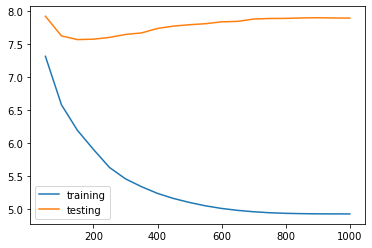

In [37]:
%%time
n,trainacc,testacc = testfeatures(trainX,trainYreg,testX,testYreg,learnlls,testlls)
plt.plot(n,trainacc,label='training')
plt.plot(n,testacc,label='testing')
plt.legend()

<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 4:</font> <font size=+1>(3 points)</font>
    <p>
    Now do the same as Question 3, but for <b>logistic regression</b>: plot the training and testing errors as a function of the number of selected features (using $p\in\{50,100,150,\dots\}$).
    <p>
    Note that this will take longer.  With an efficient logistic regression learning algorithm, my solutions finish in under 5 minutes.  For debugging, you'll want to only check one (or a few) values of $p$.
</div>
   <div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /3<br>
</div>

CPU times: user 7min 31s, sys: 1min 16s, total: 8min 47s
Wall time: 3min 42s


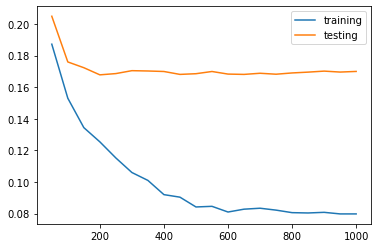

In [38]:
%%time
n,trainacc,testacc = testfeatures(trainX,trainYclass,testX,testYclass,learnlogreg,testlogreg)
plt.plot(n,trainacc,label='training')
plt.plot(n,testacc,label='testing')
plt.legend()

<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 5:</font> <font size=+1>(3 points)</font>
    <p>
        Consider the results from feature selection, above.  For <b>this problem</b>...
        <p>
        (a) In what way(s) does reducing the number of features help?  
        <p>
        (b) In what way(s) does reducing the number of features hinder?
</div>
   <div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /3<br>
</div>

### Your Answers Here
(a) It reducing the training time (although to find the features takes the same amount of time).  It reduces the testing time (very slightly).  It reduces the gap between the training and testing error (the overfitting), making the estimated error on the training set more indicative of the testing error.

(b) It reduces the overall performance.  The training and testing errors (on this problem) never get worse with more features.  